In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
opj = os.path.join
CODE_DIR = os.path.abspath('../..')
sys.path.append(opj(CODE_DIR, 'EPypes'))
sys.path.append(opj(CODE_DIR, 'RPALib'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import math
import multiprocessing as mp
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'
plt.gray()

In [4]:
from epypes import pipeline
from epypes import compgraph

from rpa import cbcalib
from rpa.io import open_image

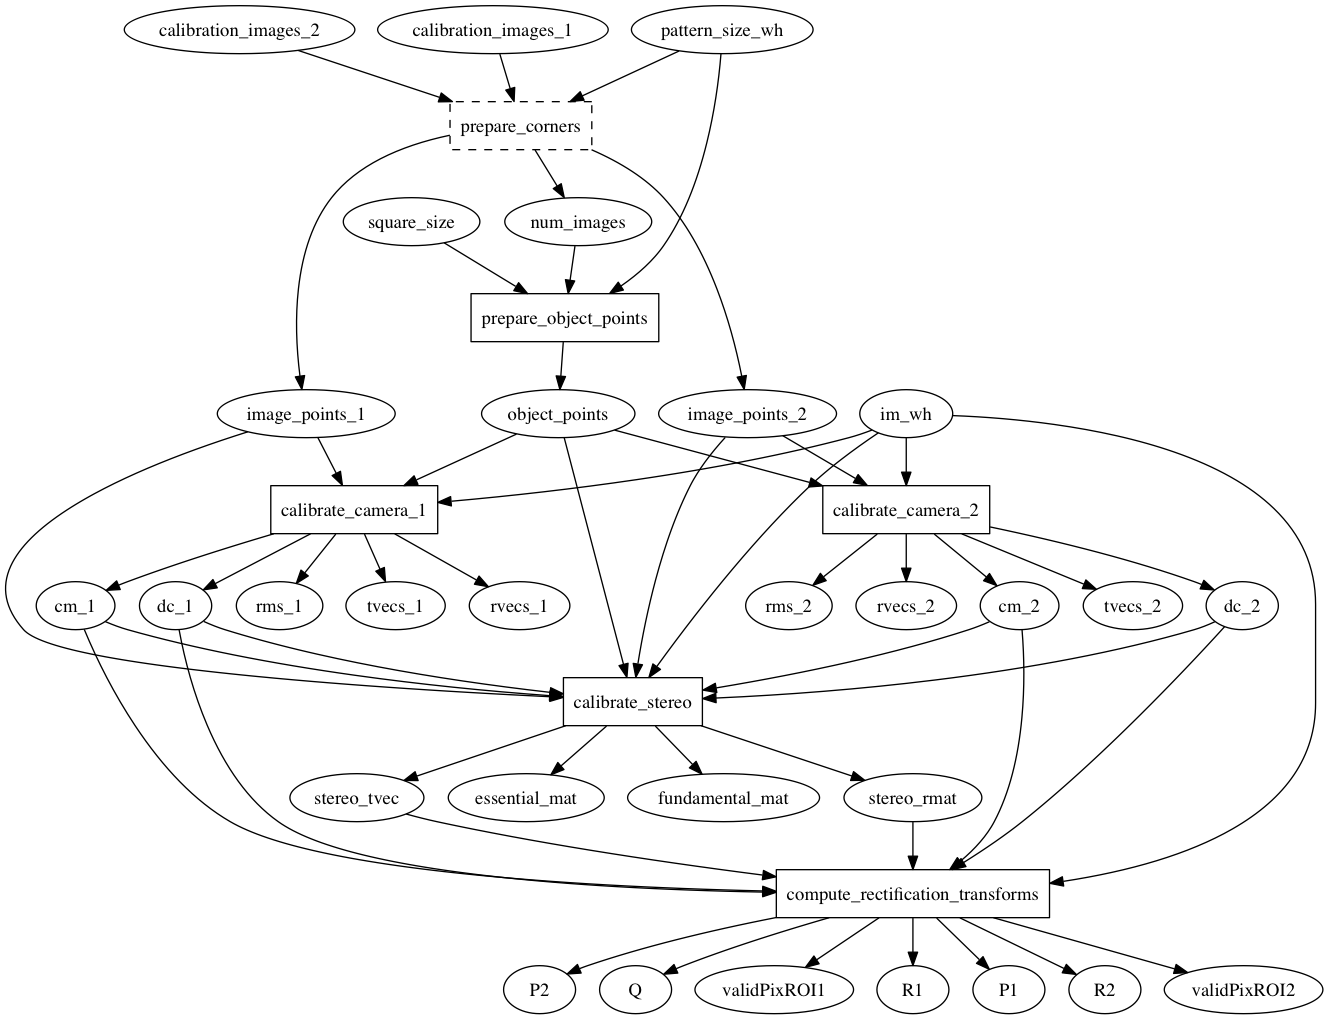

In [5]:
cg_stereocalib = cbcalib.CGCalibrateStereo()

nxpd.draw(cg_stereocalib.to_networkx())

In [6]:
cg_corners = cbcalib.CGFindCorners()

def prepare_corners_stereo(images1, images2, psize):
    
    runner1 = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})
    runner2 = compgraph.CompGraphRunner(cg_corners, frozen_tokens={'pattern_size_wh': psize})
    
    res1 = []
    res2 = []
    num_images = 0
    for im1, im2 in zip(images1, images2):
        
        runner1.run(image=im1)
        runner2.run(image=im2)
        
        both_ok = runner1.token_value('success') and runner2.token_value('success')

        if both_ok:
            res1.append(runner1.token_value('corners_np'))
            res2.append(runner1.token_value('corners_np'))
            num_images += 1
        
    return res1, res2, num_images

In [7]:
images1 = [open_image(f) for f in glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_left/*.jpg'))]
images2 = [open_image(f) for f in glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_right/*.jpg'))]
psize = (9, 6)
sq_size = 10.

#images1 = [open_image(f) for f in glob(opj(CODE_DIR, 'DATA/IMG/calib/raufoss_left/*.bmp'))]
#images2 = [open_image(f) for f in glob(opj(CODE_DIR, 'DATA/IMG/calib/raufoss_right/*.bmp'))]
#psize = (10, 8)
#sq_size = 30.

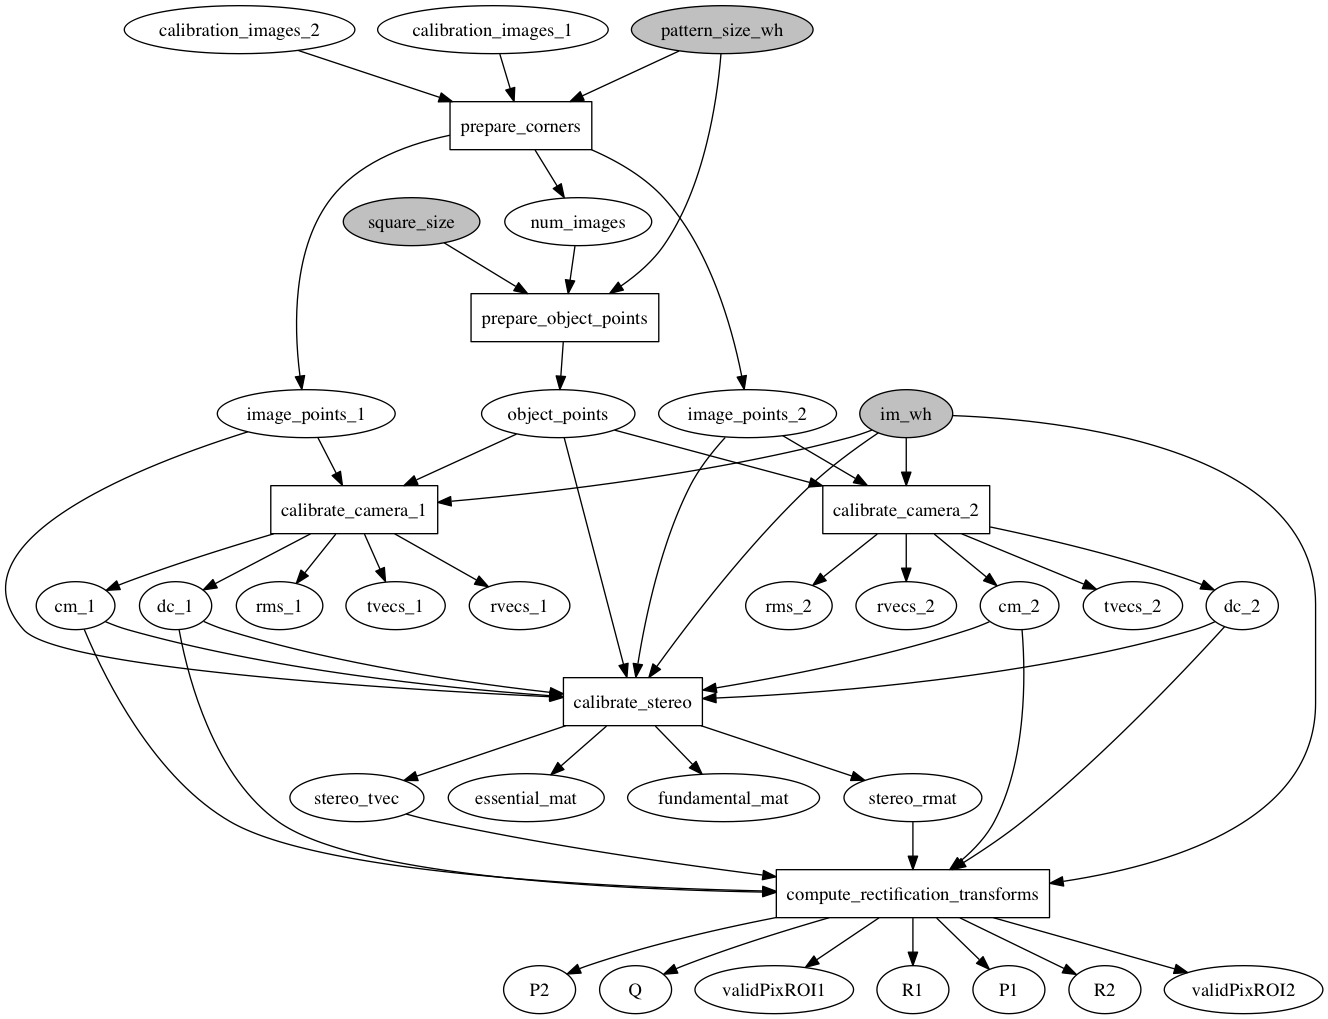

In [8]:
cg_stereocalib.swap_function('prepare_corners', prepare_corners_stereo)

runner = compgraph.CompGraphRunner(cg_stereocalib, frozen_tokens={
    'im_wh': cbcalib.get_im_wh(images1[0]),
    'pattern_size_wh': psize,
    'square_size': sq_size
    
})

nxpd.draw(runner.token_manager.to_networkx())

In [9]:
runner.run(calibration_images_1=images1, calibration_images_2=images2)

In [10]:
print('Number of calibration images opened: ', len(runner.token_value('calibration_images_1')))
print('Number of images with good corners', len(runner.token_value('image_points_1')))

Number of calibration images opened:  13
Number of images with good corners 13


In [11]:
def undistort_and_rectify_images_stereo(images1, images2, cm1, dc1, cm2, dc2, R1, R2, P1, P2):
    
    im_wh = cbcalib.get_im_wh(images1[0])
    
    maps1 = cv2.initUndistortRectifyMap(cm1, dc1, R1, P1, im_wh, m1type=cv2.CV_16SC2)
    maps2 = cv2.initUndistortRectifyMap(cm2, dc2, R2, P2, im_wh, m1type=cv2.CV_16SC2)

    interp_method = cv2.INTER_LINEAR
    
    images1_rect = [cv2.remap(im, maps1[0], maps1[1], interp_method) for im in images1]    
    images2_rect = [cv2.remap(im, maps2[0], maps2[1], interp_method) for im in images2]   
    
    return (images1_rect, images2_rect, maps1, maps2)

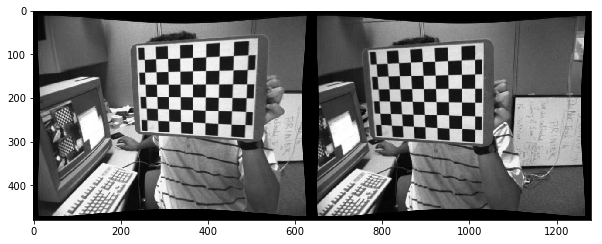

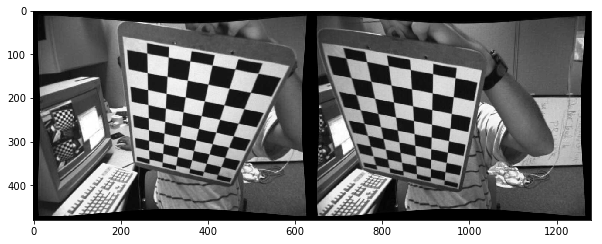

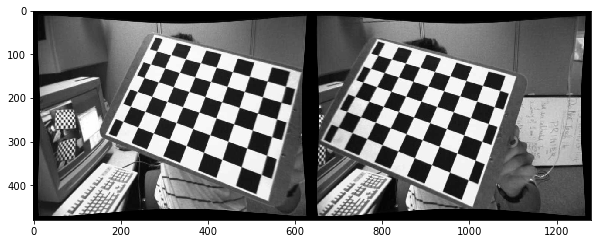

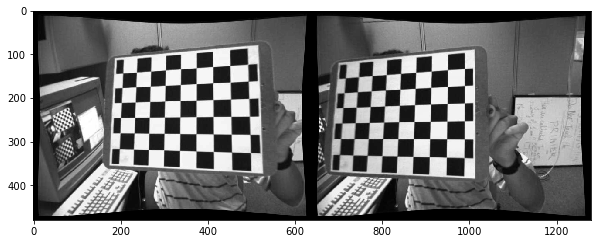

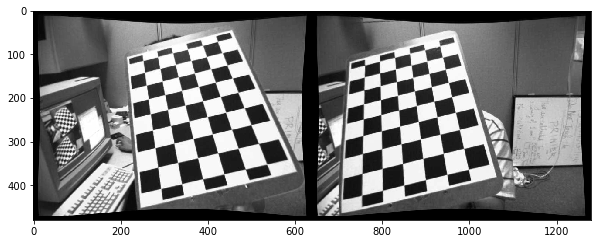

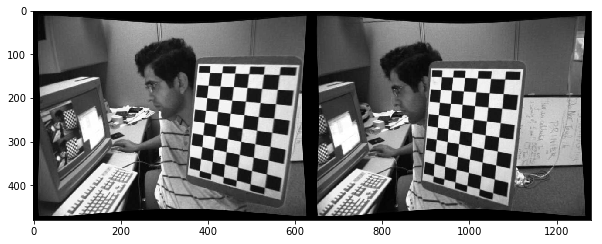

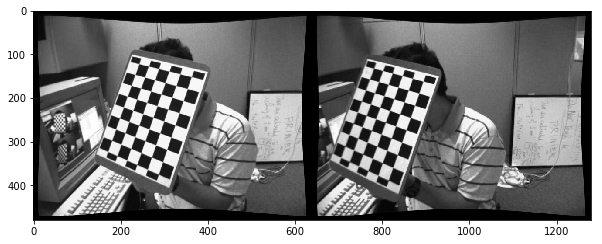

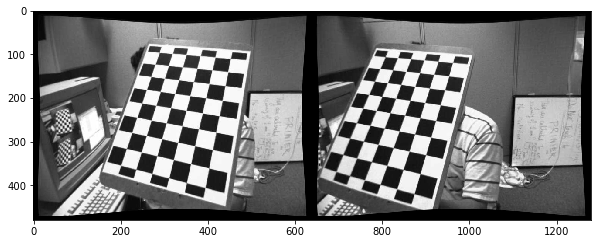

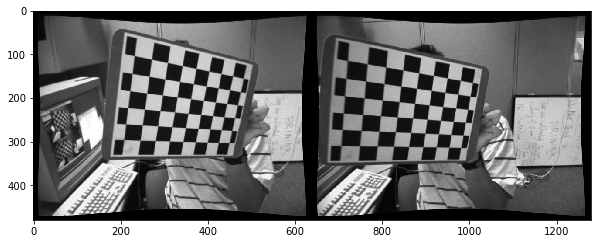

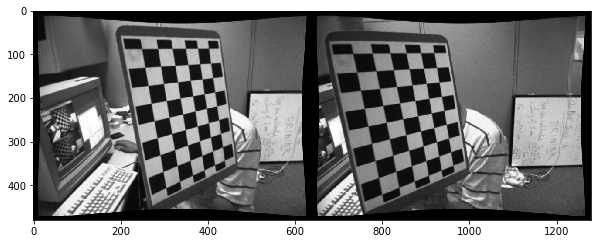

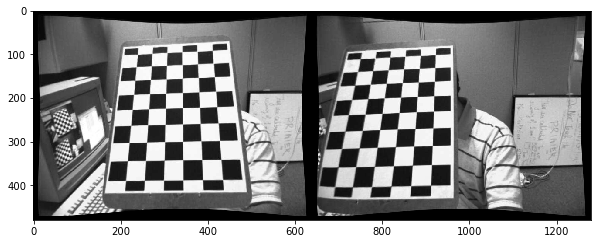

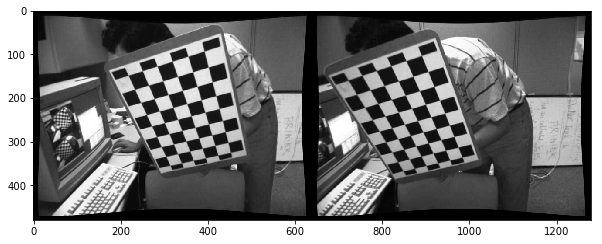

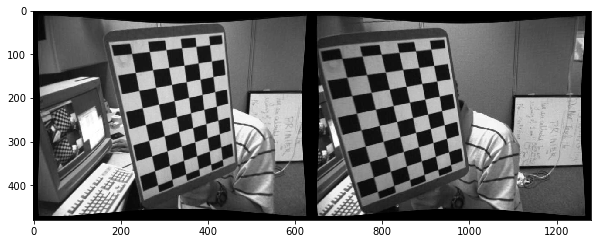

In [12]:
images1_rect, images2_rect, maps1, maps2 = undistort_and_rectify_images_stereo(
    images1,
    images2,
    runner.token_value('cm_1'),
    runner.token_value('dc_1'),
    runner.token_value('cm_2'),
    runner.token_value('dc_2'),
    runner.token_value('R1'),
    runner.token_value('R2'),
    runner.token_value('P1'),
    runner.token_value('P2')
)

for i in range(len(images1_rect)):
    plt.figure(figsize=(10, 20))
    plt.imshow(np.hstack((images1_rect[i], images2_rect[i])))